### Install the important Libraries; pyTigerGraph, Plotly Express and Pandas

In [1]:
import pyTigerGraph as tg
import plotly.express as px
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cufflinks as cf

import warnings
warnings.filterwarnings('ignore')
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

### Create a connection to the Graph

In [2]:
conn = tg.TigerGraphConnection(host="https://march-madness.i.tgcloud.io", password="password", graphname="basketball")

In [3]:
conn.apiToken = conn.getToken(conn.createSecret())

In [4]:
print(conn.gsql('ls', options=[]))

---- Graph basketball
Vertex Types:
- VERTEX Team(PRIMARY_ID id STRING) WITH STATS="OUTDEGREE_BY_EDGETYPE", PRIMARY_ID_AS_ATTRIBUTE="true"
- VERTEX Conference(PRIMARY_ID id STRING) WITH STATS="OUTDEGREE_BY_EDGETYPE", PRIMARY_ID_AS_ATTRIBUTE="true"
- VERTEX Season(PRIMARY_ID id INT) WITH STATS="OUTDEGREE_BY_EDGETYPE", PRIMARY_ID_AS_ATTRIBUTE="true"
Edge Types:
- DIRECTED EDGE IS_IN(FROM Team, TO Conference) WITH REVERSE_EDGE="reverse_IS_IN"
- DIRECTED EDGE reverse_IS_IN(FROM Conference, TO Team) WITH REVERSE_EDGE="IS_IN"
- DIRECTED EDGE RESULTS_OF(FROM Team, TO Season, gamesPlayed INT, gamesWon INT, offensiveEfficiency FLOAT, defensiveEfficiency FLOAT, powerRating FLOAT, fieldGoalAllowed FLOAT, turnoverRate FLOAT, stealRate FLOAT, reboundRate FLOAT, reboundRateAllowed FLOAT, freeThrowRate FLOAT, freeThrowRateAllowed FLOAT, twoPointRate FLOAT, twoPointRateAllowed FLOAT, threePointRate FLOAT, threePointRateAllowed FLOAT, postSeasonOutcome STRING, marchMadnessSeed INT, fieldGoal FLOAT) WIT

In [5]:
conn.getVertexTypes()

['Team', 'Conference', 'Season']

In [6]:
conn.getEdgeTypes()

['IS_IN', 'RESULTS_OF']

In [7]:
conn.getEdgeCount()

{'IS_IN': 427,
 'reverse_IS_IN': 427,
 'RESULTS_OF': 2455,
 'reverse_RESULTS_OF': 2455}

### Let's check out how many appearances each conference has made in the tournament and how they have performed

In [8]:
conferences = conn.runInstalledQuery("conferenceAppearanceAndPostseasonOutcome")[0]["result"]

In [9]:
conference = []
appearances = []
pastElite8 = []
for d in conferences:
    for key, value in d['attributes'].items():
        if(key == 'id'):
            conference.append(value)
        elif (key == '@numOtherAppearances'):
            appearances.append(value)
        elif (key == '@pastElie8'):
            pastElite8.append(value)

In [10]:
d = {'conference': conference, 'appearances': appearances, 'pastElite8': pastElite8}

In [11]:
df = pd.DataFrame(data=d)

In [12]:
df.head()

,conference,appearances,pastElite8
0,ACC,42,15
1,BE,52,11
2,B10,36,10
3,SEC,25,9
4,B12,38,7


In [13]:
fig = px.scatter(df, x="appearances", y="pastElite8", title="Conference Appearances and Who Has Made it Passed the Elite8", hover_name=conference, hover_data=['conference'], trendline="ols")
fig.show()

### Now, let's check out the top winning teams throughout the seasons

In [14]:
wins = conn.runInstalledQuery("topWinPercentages")[0]["totalGamesPerTeam"]

In [15]:
team = []
totalWins = []
totalGames = []
for w in wins:
    for key, value in w['attributes'].items():
        if(key == 'id'):
            team.append(value)
        elif (key == '@totalGames'):
            totalGames.append(value)
        elif (key == '@totalWins'):
            totalWins.append(value)

In [16]:
d2 = {'team': team, 'totalWins': totalWins, 'totalGames': totalGames}

In [17]:
df2 = pd.DataFrame(data=d2)

In [18]:
df2.head()

,team,totalWins,totalGames
0,Gonzaga,222,254
1,Villanova,210,255
2,Duke,205,258
3,Kentucky,203,260
4,Kansas,203,256


### Let's add a win/loss percentage to our dataframe

In [19]:
df2['totalLosses'] = (df2['totalGames'] - df2['totalWins'])
df2['win/loss%'] = ((df2['totalWins'] / df2['totalGames']) * 100).astype(int)

In [20]:
df2.head()

,team,totalWins,totalGames,totalLosses,win/loss%
0,Gonzaga,222,254,32,87
1,Villanova,210,255,45,82
2,Duke,205,258,53,79
3,Kentucky,203,260,57,78
4,Kansas,203,256,53,79


In [21]:
fig = px.bar(df2, x='team', y='totalWins',
             hover_data=['team'], color='team',
             labels={'totalWins':'Wins Per Team'}, height=400)
fig.show()

### Let's checkout how many times teams have actually made it to the tournament!

In [22]:
tournamentAppearances = conn.runInstalledQuery("marchMadnessAppearances")[0]["result"]

In [23]:
team = []
appearances = []
for w in tournamentAppearances:
    for key, value in w['attributes'].items():
        if(key == 'id'):
            team.append(value)
        elif (key == '@numAppearances'):
            appearances.append(value)

In [24]:
d3 = {'team': team, 'appearances': appearances}

In [25]:
df3 = pd.DataFrame(data=d3)

In [26]:
df3.head()

,team,appearances
0,North Carolina,7
1,Gonzaga,7
2,Kansas,7
3,Michigan St.,7
4,Cincinnati,7


In [27]:
fig = px.bar(df3, x='team', y='appearances',
             hover_data=['team'], color='team',
             labels={'totalWins':'Tournament Appearances Per Team'}, height=400)
fig.show()

### Let's create a new dataframe with out win loss data and our tournament appearance data

In [28]:
df4 = pd.merge(df2, df3, on="team")

In [29]:
df4

,team,totalWins,totalGames,totalLosses,win/loss%,appearances
0,Gonzaga,222,254,32,87,7
1,Villanova,210,255,45,82,7
2,Duke,205,258,53,79,7
3,Kentucky,203,260,57,78,6
4,Kansas,203,256,53,79,7
...,...,...,...,...,...,...
350,San Jose St.,41,200,159,20,0
351,Chicago St.,36,206,170,17,0
352,Little Rock,32,89,57,35,0
353,Cal Baptist,16,27,11,59,0


In [30]:
fig = px.scatter(df4, x="win/loss%", y="appearances", title="Regular Season Win % vs Tournament Appearances", hover_data=['team'], trendline="ols")
fig.show()

In [31]:
df4.iplot(
    x='totalWins',
    y='appearances',
    categories='team',
    xTitle='Total Wins',
    yTitle='Tournament Appearances',
    title='Tournament Appearances vs Regular Season Wins by Team')

### Now let's take a look at how the regular season correlates with teams that make it through the Elite 8

In [32]:
elite8 = conn.runInstalledQuery("teamsThroughElite8")[0]["result"]

In [33]:
team = []
elite8Appearances = []
for w in elite8:
    for key, value in w['attributes'].items():
        if(key == 'id'):
            team.append(value)
        elif (key == '@throughElite8'):
            elite8Appearances.append(value)

In [34]:
d5 = {'team': team, 'elite8Appearances': elite8Appearances}

In [35]:
df5 = pd.DataFrame(data=d5)

In [36]:
df5.head()

,team,elite8Appearances
0,Duke,4
1,Kentucky,4
2,Michigan,3
3,Kansas,3
4,Michigan St.,3


### Let's merge this with our win/loss data

In [37]:
df6 = pd.merge(df2, df5, on='team')

In [38]:
df6.head()

,team,totalWins,totalGames,totalLosses,win/loss%,elite8Appearances
0,Gonzaga,222,254,32,87,3
1,Villanova,210,255,45,82,2
2,Duke,205,258,53,79,4
3,Kentucky,203,260,57,78,4
4,Kansas,203,256,53,79,3


In [39]:
df6.iplot(
    x='win/loss%',
    y='elite8Appearances',
    categories='team',
    xTitle='Win/Loss %',
    yTitle='Through Elite 8 Appearances',
    title='Through Elite 8 Appearances vs Regular Season Win/Loss % by Team',
    bestfit=True,
    bestfit_colors=['blue'])

### Let's see if we can get the correlation of the win/loss percentage and Elite 8 Appearances

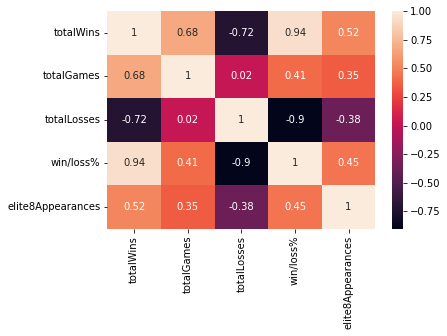

In [40]:
matrix = df6.corr().round(2)
sns.heatmap(matrix, annot=True)
plt.show()

### A strong relationship/correlation is typically considered > .75 percent. For our data and how reduced the count becomes, I would assume that anything > .60 would show a pretty strong correlation. From the data we currently have, there isn't much correlation between the regular season outcome and wether or not a team will make it to the Elite 8!

### Let's add in another piece of data, team effieciency. We'll be inluding the Average Offensive and Defensive Efficencies of the teams over the 7 seasons to see what kind of impact that has on the tournament outcomes through the Elite 8

In [41]:
efficiency = conn.runInstalledQuery("totalEfficiency")[0]["totalEfficiency"]

In [42]:
team = []
offensiveEfficiency = []
defensiveEfficiency = []
for w in efficiency:
    for key, value in w['attributes'].items():
        if(key == 'id'):
            team.append(value)
        elif (key == '@offensiveEfficiency'):
            offensiveEfficiency.append(value)
        elif (key == '@defensiveEfficiency'):
            defensiveEfficiency.append(value)

In [43]:
d7 = {'team': team, 'offensiveEfficiency': offensiveEfficiency, 'defensiveEfficiency':defensiveEfficiency}

In [44]:
df7 = pd.DataFrame(data=d7)

In [45]:
df7.head()

,team,offensiveEfficiency,defensiveEfficiency
0,Duke,122.00000,93.90000
1,Villanova,118.67142,92.92857
2,North Carolina,118.52857,93.58572
3,Gonzaga,118.35713,91.74287
4,Michigan,117.58572,94.81428


### Let's merge this with our Elite 8 Appearances

In [46]:
df8 = pd.merge(df5, df7, on='team')

In [47]:
df8.head()

,team,elite8Appearances,offensiveEfficiency,defensiveEfficiency
0,Duke,4,122.00000,93.90000
1,Kentucky,4,117.42857,92.67143
2,Michigan,3,117.58572,94.81428
3,Kansas,3,117.39999,92.30000
4,Michigan St.,3,117.17143,93.12857


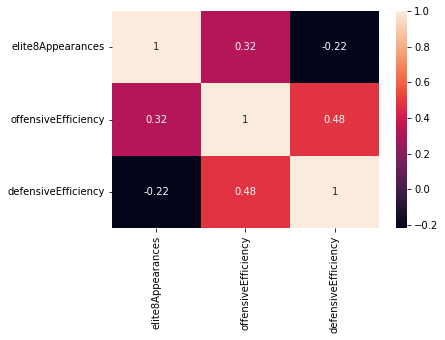

In [48]:
matrix = df8.corr().round(2)
sns.heatmap(matrix, annot=True)
plt.show()

### Regular Season offensive and defensive efficiency does not seem to be an indicator of tournament preformance either!

### Let's call a different query, one that will get all of the average of the regualr season statistics, so we can compare the correlation of all of them in one heatmap

In [50]:
seasonStats = conn.runInstalledQuery("totalSeasonStats")[0]["result"]

In [51]:
team = []
offensiveEfficiency = []
defensiveEfficiency = []
fieldGoal = []
fieldGoalAllowed = []
freeThrow = []
freeThrowAllowed = []
powerRating = []
rebound = []
reboundAllowed = []
steal = []
threePoint = []
threePointAllowed = []
turnover = []
twoPoint = []
twoPointAllowed = []
for w in seasonStats:
    for key, value in w['attributes'].items():
        if(key == 'id'):
            team.append(value)
        elif (key == '@offensiveEfficiency'):
            offensiveEfficiency.append(value)
        elif (key == '@defensiveEfficiency'):
            defensiveEfficiency.append(value)
        elif (key == '@fieldGoal'):
            fieldGoal.append(value)
        elif (key == '@fieldGoalAllowed'):
            fieldGoalAllowed.append(value)
        elif (key == '@freeThrow'):
            freeThrow.append(value)
        elif (key == '@freeThrowAllowed'):
            freeThrowAllowed.append(value)
        elif (key == '@powerRating'):
            powerRating.append(value)
        elif (key == '@steal'):
            steal.append(value)
        elif (key == '@threePoint'):
            threePoint.append(value)
        elif (key == '@threePointAllowed'):
            threePointAllowed.append(value)
        elif (key == '@turnover'):
            turnover.append(value)
        elif (key == '@twoPoint'):
            twoPoint.append(value)
        elif (key == '@twoPointAllowed'):
            twoPointAllowed.append(value)

In [68]:
d8 = {'team': team, 'offensiveEfficiency': offensiveEfficiency, 'defensiveEfficiency':defensiveEfficiency, 'fieldGoal': fieldGoal, 'fieldGoalAllowed': fieldGoalAllowed, 'freeThrow': freeThrow, 'freeThrowAllowed': freeThrowAllowed, 'powerRating': powerRating, 'steal': steal, 'threePoint': threePoint, 'threePointAllowed': threePointAllowed, 'turnover': turnover, 'twoPoint': twoPoint, 'twoPointAllowed': twoPointAllowed}

In [70]:
df9 = pd.DataFrame(data=d8)

In [71]:
df9.head()

,team,offensiveEfficiency,defensiveEfficiency,fieldGoal,fieldGoalAllowed,freeThrow,freeThrowAllowed,powerRating,steal,threePoint,threePointAllowed,turnover,twoPoint,twoPointAllowed
0,Duke,122.00000,93.90000,54.61428,47.08571,265.50000,200.20000,6.6499,18.41428,37.50000,30.90000,16.01429,53.64286,47.28571
1,Villanova,118.67142,92.92857,54.64286,47.54286,269.79999,216.89999,6.4917,20.07143,36.58571,33.44286,17.40000,54.58572,46.08571
2,North Carolina,118.52857,93.58572,51.42857,47.94286,231.09999,222.70000,6.5262,18.55714,35.27143,33.95714,16.82857,50.70000,46.10000
3,Gonzaga,118.35713,91.74287,56.54286,44.41429,261.50000,208.99998,6.6063,17.70000,37.80000,31.77143,16.42857,56.54286,42.75714
4,Michigan,117.58572,94.81428,53.81429,49.05714,206.00002,184.40001,6.3649,18.58571,37.04286,33.31429,14.51429,52.64286,48.68571


### Let's merge this with our Elite 8 Appearances

In [72]:
df10 = pd.merge(df5, df9, on='team')

In [73]:
df10.head()

,team,elite8Appearances,offensiveEfficiency,defensiveEfficiency,fieldGoal,fieldGoalAllowed,freeThrow,freeThrowAllowed,powerRating,steal,threePoint,threePointAllowed,turnover,twoPoint,twoPointAllowed
0,Duke,4,122.00000,93.90000,54.61428,47.08571,265.50000,200.20000,6.6499,18.41428,37.50000,30.90000,16.01429,53.64286,47.28571
1,Kentucky,4,117.42857,92.67143,52.17143,44.98571,302.00000,232.10001,6.4606,18.12857,35.10000,31.32857,17.55714,52.00000,44.08572
2,Michigan,3,117.58572,94.81428,53.81429,49.05714,206.00002,184.40001,6.3649,18.58571,37.04286,33.31429,14.51429,52.64286,48.68571
3,Kansas,3,117.39999,92.30000,54.11429,46.18571,264.50000,231.00002,6.5703,17.97143,37.87143,33.18571,18.48571,52.75714,44.32857
4,Michigan St.,3,117.17143,93.12857,54.38572,44.54286,236.00000,238.70000,6.5071,16.14286,38.62857,32.24286,18.78571,52.44286,42.52857


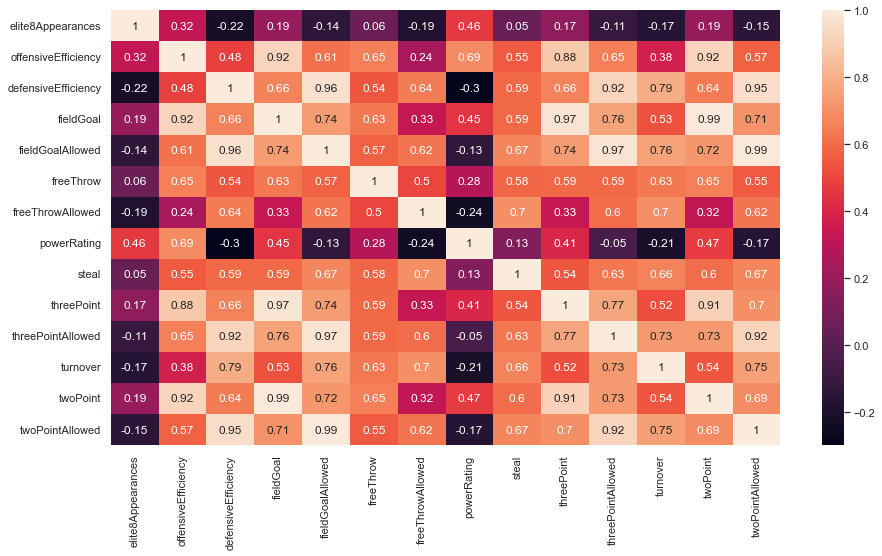

<Figure size 1080x576 with 0 Axes>

In [76]:
matrix = df10.corr().round(2)
sns.heatmap(matrix, annot=True)
plt.figure(figsize = (15,8))
plt.show()

### As we can see from the heatmap above, the power rating has the only clear and strong correlation to the a team's Elite 8 Appearances at .46. The power ratings is made up of three componenets: a team's winning percentage, the average opponent's winning percentage, and the average opponent's opponent's winning percentage. Offensive efficiency has the next strongest correlation at .32. This still isn't the strongest correlation, but it is better than all of the other factors. 